In [1]:
import requests
import os

In [2]:
MNIST_PATH= "../datasets/mnist"

In [4]:
if not os.path.exists(MNIST_PATH):
    os.mkdir(MNIST_PATH)

In [6]:
train_imgage_url = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
train_label_url = "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"
test_imgage_url = "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz"
test_label_url = "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"

train_imgage_res = requests.get(train_imgage_url).content
train_label_res = requests.get(train_label_url).content
test_imgage_res = requests.get(test_imgage_url).content
test_label_res  = requests.get(test_label_url).content

In [7]:
MNIST_PATH

'../datasets/mnist'

In [9]:
with open(MNIST_PATH+"/train-images-idx3-ubyte.gz","wb") as f:
    f.write(train_imgage_res)

In [10]:
with open(MNIST_PATH+"/train-labels-idx1-ubyte.gz","wb") as f:
    f.write(train_label_res)

In [11]:
with open(MNIST_PATH+"/test-images-idx3-ubyte.gz","wb") as f:
    f.write(test_imgage_res)

In [12]:
with open(MNIST_PATH+"/test-labels-idx1-ubyte.gz","wb") as f:
    f.write(test_label_res)

In [17]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [18]:
mnist_data = tf.keras.datasets.mnist

In [20]:
(x_train,y_train),(x_test,y_test)=mnist_data.load_data()

In [21]:
x_train.shape

(60000, 28, 28)

In [22]:
y_train.shape

(60000,)

In [27]:
import numpy as np

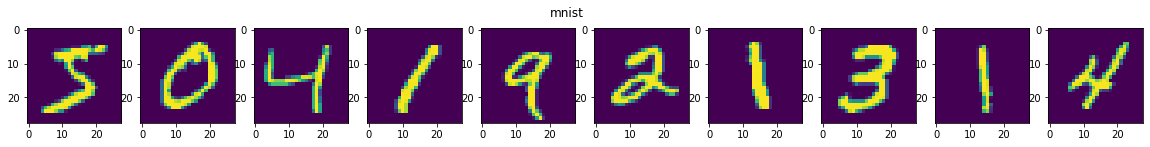

In [31]:
fig = plt.figure(figsize=(20,2))

for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    ax.imshow(np.squeeze(x_train[i]))   
plt.suptitle("mnist")
plt.show()

In [32]:
# 图像增强
image_agment = tf.keras.preprocessing.image.ImageDataGenerator(
   rescale=1.,#缩小图像范围至0-1，由于以及提前缩小，此处不用设置
    rotation_range=45,#随机旋转45度
    width_shift_range=0.15,#宽度偏移
    height_shift_range=0.15,#高度偏移
    horizontal_flip=False,#是否水平翻转
    zoom_range=0.5,#图像随机缩放50%
)

In [44]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)

In [45]:
image_agment.flow(x_train,batch_size=32,shuffle=False)

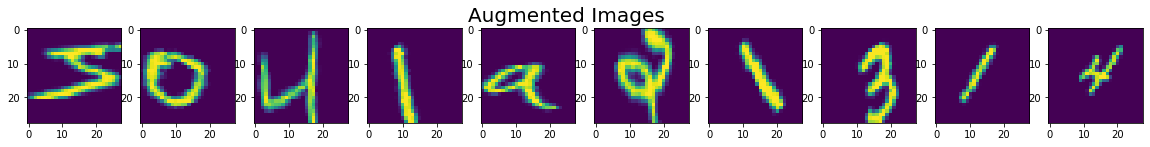

In [46]:
#增强后的数据
fig = plt.figure(figsize=(20, 2))
for x_batch in image_agment.flow(x_train[:12], batch_size=12, shuffle=False):
    for i in range(10):
        ax = fig.add_subplot(1, 10, i + 1)
        ax.imshow(np.squeeze(x_batch[i]))
    fig.suptitle('Augmented Images', fontsize=20)
    plt.show()
    break

#### 模型搭建

In [80]:
x_test =x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)

In [81]:
x_test.shape

(10000, 28, 28, 1)

In [69]:
help(tf.keras.layers.Flatten)

Help on class Flatten in module keras.layers.core:

class Flatten(keras.engine.base_layer.Layer)
 |  Flattens the input. Does not affect the batch size.
 |  
 |  Note: If inputs are shaped `(batch,)` without a feature axis, then
 |  flattening adds an extra channel dimension and output shape is `(batch, 1)`.
 |  
 |  Args:
 |    data_format: A string,
 |      one of `channels_last` (default) or `channels_first`.
 |      The ordering of the dimensions in the inputs.
 |      `channels_last` corresponds to inputs with shape
 |      `(batch, ..., channels)` while `channels_first` corresponds to
 |      inputs with shape `(batch, channels, ...)`.
 |      It defaults to the `image_data_format` value found in your
 |      Keras config file at `~/.keras/keras.json`.
 |      If you never set it, then it will be "channels_last".
 |  
 |  Example:
 |  
 |  >>> model = tf.keras.Sequential()
 |  >>> model.add(tf.keras.layers.Conv2D(64, 3, 3, input_shape=(3, 32, 32)))
 |  >>> model.output_shape
 |  

In [87]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten()) #打平数据
model.add(tf.keras.layers.Dense(128,activation="relu")) # 128个神经元 激活函数为relu
model.add(tf.keras.layers.Dense(64,activation="relu"))  # 64个神经元 激活函数为relu
model.add(tf.keras.layers.Dense(10,activation="softmax")) # 输出层10个类别， 激活函数为softmax

In [88]:
#配置神经网络训练方法
#采用adam优化器
#损失函数为交叉熵损失函数,由于输出为概率形式，所以from_logits为False
#标签为数值形式，输出为概率的one-hot形式，因此精度评估采用sparse_categorical_accuracy
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['sparse_categorical_accuracy']
)

In [89]:
# #断点存续
# import os
# check_point_path='.checkpoin/mnist.ckpt'#检查是否已经存储过变量，如果存储了，则直接加载
# if os.path.exists(check_point_path+'.index'):
#     print('加载模型......')
#     model.load_weights(check_point_path)
# cp_callback=tf.keras.callbacks.ModelCheckpoint(filepath=check_point_path,save_best_only=True,save_weights_only=True)#设置存储方式

In [90]:
# validation_freq 表示经过多少个周期后进行一次验证
history = model.fit(
    image_agment.flow(x_train,y_train,batch_size=64),
    validation_data= (x_test,y_test),
    epochs=5,
    validation_freq=1  
)

Epoch 1/5
938/938 [==============================] - 12s 13ms/step - loss: 3.3455 - sparse_categorical_accuracy: 0.1218 - val_loss: 2.2049 - val_sparse_categorical_accuracy: 0.1597
Epoch 2/5
938/938 [==============================] - 12s 13ms/step - loss: 2.1846 - sparse_categorical_accuracy: 0.1676 - val_loss: 2.0052 - val_sparse_categorical_accuracy: 0.2188
Epoch 3/5
938/938 [==============================] - 12s 13ms/step - loss: 2.0882 - sparse_categorical_accuracy: 0.2006 - val_loss: 1.8605 - val_sparse_categorical_accuracy: 0.2664
Epoch 4/5
938/938 [==============================] - 12s 13ms/step - loss: 1.9301 - sparse_categorical_accuracy: 0.2781 - val_loss: 1.5638 - val_sparse_categorical_accuracy: 0.4437
Epoch 5/5
938/938 [==============================] - 12s 13ms/step - loss: 1.7196 - sparse_categorical_accuracy: 0.3670 - val_loss: 1.2168 - val_sparse_categorical_accuracy: 0.5995


In [91]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, None)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_24 (Dense)             (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


In [101]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

In [99]:
history.history['loss']

[3.345534324645996,
 2.1846110820770264,
 2.088224411010742,
 1.9301226139068604,
 1.7195814847946167]

In [102]:
history.history['sparse_categorical_accuracy']

[0.12178333103656769,
 0.16763333976268768,
 0.20063333213329315,
 0.2781499922275543,
 0.3670499920845032]

In [103]:
history.history['val_loss']

[2.2048895359039307,
 2.0052225589752197,
 1.8604605197906494,
 1.563791275024414,
 1.2168188095092773]

In [104]:
history.history['val_sparse_categorical_accuracy']

[0.15970000624656677,
 0.21879999339580536,
 0.266400009393692,
 0.44369998574256897,
 0.5995000004768372]

In [105]:
import seaborn as sns 
from matplotlib.font_manager import FontManager,FontProperties

In [106]:
myfont = FontProperties(fname="../../../../../simhei.ttf")

In [107]:
myfont

In [113]:
import pandas as pd

In [115]:
res = pd.DataFrame(history.history)

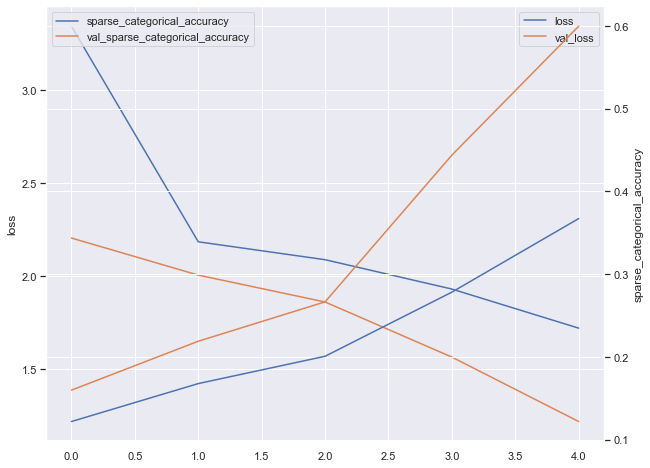

In [135]:
fig = plt.figure(figsize=(10,8))
ax = fig.subplots()
ax2 =ax.twinx()

sns.lineplot(data=res,x=res.index,y="loss",ax=ax,label="loss")
sns.lineplot(data=res,x=res.index,y="sparse_categorical_accuracy",ax=ax2,label="sparse_categorical_accuracy")

sns.lineplot(data=res,x=res.index,y="val_loss",ax=ax,label="val_loss")
sns.lineplot(data=res,x=res.index,y="val_sparse_categorical_accuracy",ax=ax2,label="val_sparse_categorical_accuracy")

plt.legend()

In [136]:
history.model.save("./outputs/hand_write")

INFO:tensorflow:Assets written to: ./outputs/hand_write\assets


In [137]:
hand_write_model = tf.keras.models.load_model("./outputs/hand_write")

In [138]:
hand_write_model

In [139]:
hand_write_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, None)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_24 (Dense)             (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________
